In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import scipy.stats as stats
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

deals = pd.read_parquet('deals.parquet')
companies = pd.read_parquet('companies.parquet')
deals = deals.drop(['DealSynopsis', 'NativeCurrencyOfDeal', 'CompanyName', 'RowID', 'LastUpdated'], axis = 1)
deals_sorted = deals.sort_values(by=['CompanyID', 'DealNo'])

prelim_company = companies.drop(['FacebookProfileURL', 'TwitterProfileURL', 'LinkedInProfileURL',
       'PrimaryContactPBId', 'PrimaryContactFirstName',
       'PrimaryContactLastName', 'PrimaryContactMiddle',
       'PrimaryContactPrefix', 'PrimaryContactSuffix', 'PrimaryContact',
       'PrimaryContactTitle', 'RowID', 'CompanyAlsoKnownAs', 'CompanyFormerName',
       'CompanyLegalName', 'Description', 'Website', 'TotalRaisedNativeAmount', 'TotalRaisedNativeCurrency', 'DescriptionShort', 'FinancingStatusNote',
       'FinancingStatusNoteAsOfDate', 'Keywords', 'CompanyName', 'LastUpdated' 
       ], axis = 1)

df = pd.merge(deals, prelim_company, left_on= 'CompanyID', right_on= 'CompanyID', how = 'left')
df['ContingentPayout'].fillna(0, inplace= True)
df = df.sort_values(by=['CompanyID', 'DealNo'])

df.head()

/var/folders/h8/frp0f1bd0v32l04p93kbg3f00000gn/T/ipykernel_29832/2753154684.py:24: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['ContingentPayout'].fillna(0, inplace= True)


,CompanyID,DealNo,DealDate,AnnouncedDate,DealSize,DealStatus,DealSizeStatus,PremoneyValuation,PostValuation,PostValuationStatus,...,OwnershipStatus,OwnershipStatusDate,Universe,Employees_y,EmployeeAsOfDate,Exchange,Ticker,YearFounded,ParentCompany,ParentCompanyID
25191,100022-14,1,2014-10-30,NaT,0.400000,Completed,Actual,NaN,NaN,None,...,Privately Held (backing),10/30/2014,"M&A, Venture Capital",52.0,11/24/2022,None,None,2014.0,None,None
24926,100022-14,2,2015-02-16,NaT,0.050000,Completed,Actual,NaN,NaN,None,...,Privately Held (backing),10/30/2014,"M&A, Venture Capital",52.0,11/24/2022,None,None,2014.0,None,None
23958,100022-14,3,2016-02-10,2015-09-01,1.175000,Completed,Actual,19.999999,21.174999,Actual,...,Privately Held (backing),10/30/2014,"M&A, Venture Capital",52.0,11/24/2022,None,None,2014.0,None,None
19779,100022-14,4,2018-12-26,NaT,2.999999,Completed,Actual,35.000000,37.999999,Actual,...,Privately Held (backing),10/30/2014,"M&A, Venture Capital",52.0,11/24/2022,None,None,2014.0,None,None
17480,100022-14,5,2020-01-22,2019-06-15,5.099998,Completed,Actual,40.000000,45.099998,Actual,...,Privately Held (backing),10/30/2014,"M&A, Venture Capital",52.0,11/24/2022,None,None,2014.0,None,None


## Preprocessing 

In [7]:
# maps, functions etc
deal_class_order = {
   'Out of Business': -1,
   'Bankruptcy': -1,
   'Other': 1,
   'Individual': 2,
   'Venture Capital': 3, 
   'Debt': 4,
   'Corporate': 5,
   'Private Equity': 6,
   'Public Investment': 7,
   'Hedge Fund': 8
}

# for ordering funding stages (series A, AA, A1, B1)
def order_letters_and_nums(x):
    if x == '1' or x=='2' or x=='3':
        return 1
    elif x == 'Angel' or x == 'Seed':
        return 0
    elif x is None:
        return None
    else:
        return sorted([i for i in df['funding_stages'].unique() if i not in [None,'1', '2', '3']]).index('A') + 2

# for binning business status
def business_status_bins(x):
    if x in ['Startup', 'Stealth', 'Product In Beta Test', 'Product Development', 'Product In Beta Test', 'Pre-Clinical Trials']:
        return 1
    elif x in ['Clinical Trials - Phase 1', 'Clinical Trials - Phase 2', 'Clinical Trials - Phase 3', 'Clinical Trials - Phase 4']:
        return 2
    elif x in ['Restart', 'Bankruptcy: Admin/Reorg']:
        return 0
    elif x in ['Generating Revenue', 'Generating Revenue/Not Profitable']:
        return 3
    elif x in ['Profitable']:
        return 4
    elif x in ['Out of Business', 'Bankruptcy: Liquidation']:
        return -1
    else:
        return np.nan
    
# for ordering vc rounds
def encode_VCRounds(x):
     if pd.isnull(x):
        return -1
     elif x == 'Angel':
        return 0
     else:
         return int(x.split()[0].rstrip('stndrdth'))

In [8]:
# features from the past
df['Prev_DealSize'] = df.groupby('CompanyID')['DealSize'].shift(1)
df['Prev_RaisedToDate'] = df.groupby('CompanyID')['RaisedToDate'].shift(1)
df['Prev_TotalInvestedCapital'] = df.groupby('CompanyID')['TotalInvestedCapital'].shift(1)
df['Prev_TotalInvestedEquity']= df.groupby('CompanyID')['TotalInvestedEquity'].shift(1)
df['Prev_PostValuation']= df.groupby('CompanyID')['PostValuation'].shift(1)

# 1 if there exists parent company else 0
df['is_ParentCompany']= df['ParentCompany'].notna()

# feature to represent funding stages
df['funding_stages']= df['DealType2'].apply(lambda x: None if x is None else (x.split()[1][0] if 'Series' in x.split() else ('Angel' if 'Angel' in x.split() else ('Seed' if 'Seed' in x.split() else None))))
df['funding_stages'] = df['funding_stages'].apply(order_letters_and_nums)

# impute deal class
df.loc[(df['DealClass'].isna()) & (df['DealType'] == 'Platform Creation'), 'DealClass'] = 'Private Equity'
df.loc[df['DealClass'].isna(), 'DealClass'] = 'Other'

# give orders to deal class
df['DealClass_order'] = df['DealClass'].map(deal_class_order)

# imputing debt
df.loc[df['DebtRaisedInRound'].isna() & df['Debts'].isna(), 'DebtRaisedInRound'] = 0

# deal class one hot encoding
lb = LabelBinarizer()
lb.fit_transform(df['DealClass'])
encode_DealClass = pd.DataFrame(lb.fit_transform(df['DealClass']),
    columns=[f'DealClass_{label}' for label in lb.classes_],
    index= df.index
)
df = pd.concat([df, encode_DealClass], axis=1)

# feature to represent vc rounds
df['VCRound'] = df['VCRound'].apply(encode_VCRounds)
df['AddOn'] = df['AddOn'].apply(lambda x: x == 'Yes')

# business status ORDER
df['BusinessStatus_x_ordinal'] = df['BusinessStatus_x'].map(business_status_bins)

# business status one hot encoding
lb = LabelBinarizer()
lb.fit_transform(df['BusinessStatus_x'].fillna('NA'))
encode_BusinessStatus_x = pd.DataFrame(lb.fit_transform(df['BusinessStatus_x'].fillna('NA')),
    columns=[f'BusinessStatus_x_{label}' for label in lb.classes_],
    index= df.index
)
df = pd.concat([df, encode_BusinessStatus_x], axis=1)

# financing status one hot encoding
lb = LabelBinarizer()
lb.fit_transform(df['FinancingStatus'].fillna('NA'))
encode_FinancingStatus = pd.DataFrame(lb.fit_transform(df['FinancingStatus'].fillna('NA')),
    columns=[f'FinancingStatus_{label}' for label in lb.classes_],
    index= df.index
)
df = pd.concat([df, encode_FinancingStatus], axis=1)

# ownership status one hot encoding
lb = LabelBinarizer()
lb.fit_transform(df['OwnershipStatus'].fillna('NA'))
encode_OwnershipStatus = pd.DataFrame(lb.fit_transform(df['OwnershipStatus'].fillna('NA')),
    columns=[f'OwnershipStatus_{label}' for label in lb.classes_],
    index= df.index
)
df = pd.concat([df, encode_OwnershipStatus], axis=1)

# encoding universe
mlb = MultiLabelBinarizer()
encode_Universe = pd.DataFrame( mlb.fit_transform(df['Universe'].apply(lambda x: [i.strip() for i in x.split(',')])),
    columns=[f'is_{label}' for label in mlb.classes_],
    index= df.index
)
df = pd.concat([df, encode_Universe], axis=1)

In [170]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
data = df.dropna(subset = ['DealSize'])
X = data[[
'PostValuation', 
    'RaisedToDate',
  'TotalInvestedCapital',
  'InvestorOwnership',
  'TotalInvestedEquity',
  'TotalNewDebt',
 'DebtRaisedInRound',
  'TotalRaised',
  'YearFounded', 'ContingentPayout',
  'Prev_DealSize', 
       'Prev_RaisedToDate', 'Prev_TotalInvestedCapital',
       'Prev_TotalInvestedEquity', 'Prev_PostValuation',
'is_Debt Financed', 'is_M&A','is_Other Private Companies', 'is_Pre-venture',	'is_Private Equity', 'is_Publicly Listed','is_Venture Capital',
'AddOn', 
 'DealClass_order', 
'BusinessStatus_x_ordinal',
'VCRound',
   'FinancingStatus_Accelerator/Incubator Backed',
       'FinancingStatus_Angel-Backed',
       'FinancingStatus_Corporation',
       'FinancingStatus_Failed Transaction (Angel)',
       'FinancingStatus_Failed Transaction (M&A)',
       'FinancingStatus_Failed Transaction (PE)',
       'FinancingStatus_Failed Transaction (VC)',
       'FinancingStatus_Formerly Accelerator/Incubator backed',
       'FinancingStatus_Formerly Angel backed',
       'FinancingStatus_Formerly PE-Backed',
       'FinancingStatus_Formerly Private Debt Financed',
       'FinancingStatus_Formerly VC-backed', 'FinancingStatus_NA',
       'FinancingStatus_Pending Transaction (Angel)',
       'FinancingStatus_Pending Transaction (Debt)',
       'FinancingStatus_Pending Transaction (M&A)',
       'FinancingStatus_Pending Transaction (PE)',
       'FinancingStatus_Pending Transaction (VC)',
       'FinancingStatus_Potential Target',
       'FinancingStatus_Private Debt Financed',
       'FinancingStatus_Private Equity-Backed',
       'FinancingStatus_Venture Capital-Backed',
      'is_ParentCompany',
       'OwnershipStatus_Acquired/Merged',
       'OwnershipStatus_Acquired/Merged (Operating Subsidiary)',
       'OwnershipStatus_In IPO Registration',
       'OwnershipStatus_Out of Business',
       'OwnershipStatus_Privately Held (backing)',
       'OwnershipStatus_Privately Held (no backing)',
       'OwnershipStatus_Publicly Held',
        'funding_stages'
 ]]
y = np.log1p(data['DealSize']) 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
rf = RandomForestRegressor()
rf.fit(X_train, y_train)
print(rf.score(X_test, y_test))

0.9808532802039702


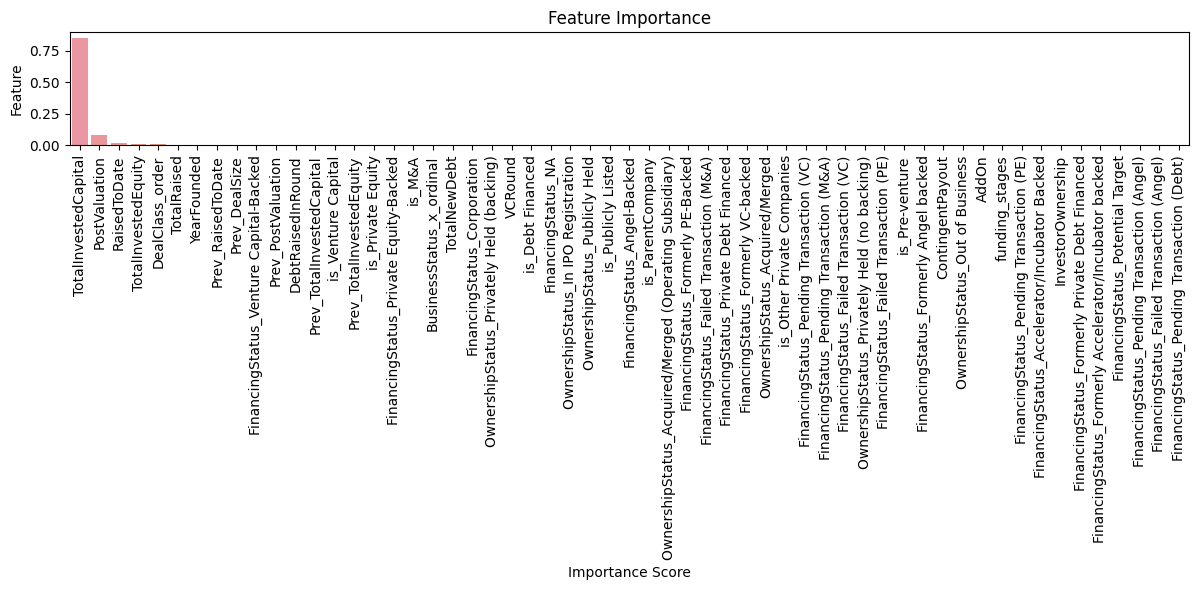

In [171]:
plt.figure(figsize=(12, 6))
feature_importance = pd.DataFrame({"Scores": rf.feature_importances_, 'Feature': X.columns}).sort_values('Scores', ascending=False).reset_index().drop('index', axis=1)
sns.barplot(y='Scores', x='Feature', data=feature_importance)
plt.title('Feature Importance')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.xticks(rotation=90) 
plt.tight_layout()
plt.show()


In [177]:
data = df.dropna(subset = ['DealSize'])
X = data[feature_importance[feature_importance['Scores'] > 0.001]['Feature']]
y = np.log1p(data['DealSize']) 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
rf = RandomForestRegressor()
rf.fit(X_train, y_train)
print(rf.score(X_test, y_test))

0.9808962147354195


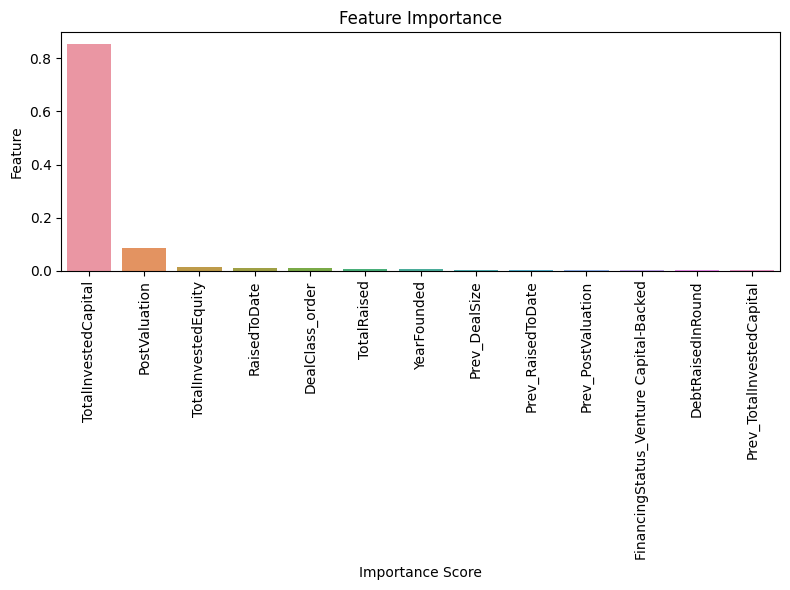

In [178]:
plt.figure(figsize=(8, 6))
feature_importance = pd.DataFrame({"Scores": rf.feature_importances_, 'Feature': X.columns}).sort_values('Scores', ascending=False).reset_index().drop('index', axis=1)
sns.barplot(y='Scores', x='Feature', data=feature_importance)
plt.title('Feature Importance')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.xticks(rotation=90) 
plt.tight_layout()
plt.show()


In [180]:
y_pred = rf.predict(X_test)
print('Final Score:', rf.score(X_test, y_test))
print('Final RMSE:', np.sqrt(mean_squared_error(y_test, y_pred)))

Final Score: 0.9808962147354195
Final RMSE: 0.2644228292295443


### Lasso 

In [123]:
from sklearn.linear_model import LassoCV
# feature selection with lasso
features_to_transform = []

for i, feature in enumerate(df.select_dtypes('float').columns):
    if df[feature].skew() > 1:
        features_to_transform.append(feature)

In [126]:
data = df.dropna(subset = ['DealSize', 'PercentAcquired', 'PostValuation', 'PremoneyValuation',
       'RaisedToDate', 'TotalInvestedCapital', 'InvestorOwnership',
       'TotalInvestedEquity', 'TotalNewDebt', 'DebtRaisedInRound',
       'ContingentPayout', 'TotalRaised', 
       'YearFounded', 'Prev_DealSize', 'Prev_RaisedToDate',
       'Prev_TotalInvestedCapital', 'Prev_TotalInvestedEquity',
       'Prev_PostValuation', 'funding_stages', 'BusinessStatus_x_ordinal'])
data[features_to_transform] = np.log1p(data[features_to_transform])
X = data[[
        'PercentAcquired', 'PostValuation', 'PremoneyValuation',
       'RaisedToDate', 'TotalInvestedCapital', 'InvestorOwnership',
       'TotalInvestedEquity', 'TotalNewDebt', 'DebtRaisedInRound',
       'ContingentPayout', 'TotalRaised', 
       'YearFounded', 'Prev_DealSize', 'Prev_RaisedToDate',
       'Prev_TotalInvestedCapital', 'Prev_TotalInvestedEquity',
       'Prev_PostValuation', 'funding_stages', 'BusinessStatus_x_ordinal']]
y = data['DealSize']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
lasso = LassoCV(cv=5).fit(X_train, y_train)
lasso.score(X_test, y_test)

/var/folders/h8/frp0f1bd0v32l04p93kbg3f00000gn/T/ipykernel_29832/1621949784.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[features_to_transform] = np.log1p(data[features_to_transform])


0.9999276198365626

In [127]:
import statsmodels.api as sm
X_train = X_train[X_train.columns[np.where(lasso.coef_ != 0)]]
X_test = X_test[X_test.columns[np.where(lasso.coef_ != 0)]]
X_with_const = sm.add_constant(X_train) 
model = sm.OLS(y_train, X_with_const)   
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:               DealSize   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                 6.385e+04
Date:                Thu, 31 Jul 2025   Prob (F-statistic):               0.00
Time:                        10:21:02   Log-Likelihood:                 534.66
No. Observations:                 250   AIC:                            -1055.
Df Residuals:                     243   BIC:                            -1031.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.0251 

In [116]:
from sklearn.metrics import r2_score
y_pred = results.predict(sm.add_constant(X_test))

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
print(f"RMSE: {rmse}")
print(f"R2: {r2}")

RMSE: 0.008565407037486874
R2: 0.9999433543488775


## Remarks
Due to the nature of the data with alot of missingness and many features, I felt like tree-based models would be the most suitable, given their ability to handle missing values, ability to capture non-linearities and handle interaction terms between predictors. Thus, I implemented both a random forest model to estimate DealSize. 

I also fit the data to a linear regression model because it provides a baseline comparison and allows for interpretability of feature effects through coefficients and p-values. 

#### Linear Regression 
- Training methodology
I trained a linear regression model with lasso regularization on all my numerical features, and select the most important features determined by coefficients. Lasso’s ability to shrink uninformative coefficients to zero provided a mechanism for feature selection and model simplification. After selecting features with non-zero coefficients,I refit the model using OLS to obtain interpretable estimates and p-values.
- Limitations
One limitation of the linear regression is that it does not handle missing data well, so without all the features being present, the model cannot be used to impute PostValuation. 

#### Random Forests
- Training methodology
I fit a random forest with all my features, and select the most important features determined by feature importance score. Those with a feature importance < 0.01 are eliminated. I then performed Gridsearch to tune hyperparameters like max depth, criterion, max features, min samples leaf, number of estimators, and min samples split. 
- Limitations
One limitation of these models is that all entries associated with a Deal Class of Bankruptcy or Out of Business contain missing valuation data, making it impossible for the models to learn from these cases. As a result, predictions for such companies are currently unsupported and should be revisited if valuation data becomes available in the future.
Random Forests are also far less interpretable compared to Linear Regression models, which could be a problem if the model is intended to inform decision-making by stakeholders who require transparency. Besides, random forests performs less well than XGBoost when fine-grained prediction accuracy is needed.

#### Final notes
- The linear regression model actually performed better than the random forest in predicting DealSize. This may be because the relationship between the predictors and DealSize are largely linear with little interaction effects or non-linearities. As a result, DealSize likely does not benefit from the additional complexity introduced by ensemble methods like random forests. The simplicity and interpretability of linear regression may have allowed it to generalize better to unseen data in this context.

### Relationship with PostValuation

Text(0.5, 1.0, 'log(DealSize)vs log(PostValuation)')

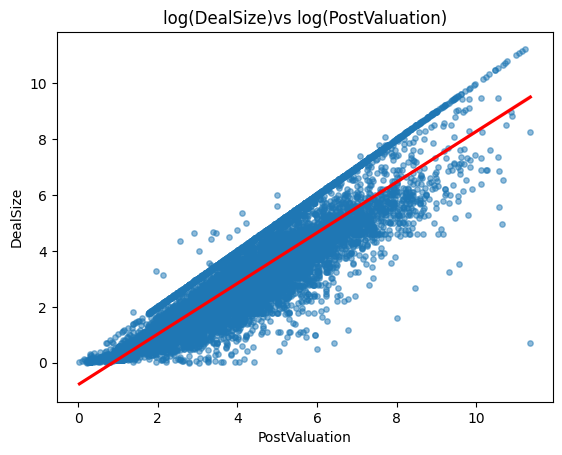

In [137]:
data = df.dropna(subset = ['DealSize',  'PostValuation'])
sns.regplot(data=data, x=np.log1p(data['PostValuation']), y=np.log1p(data['DealSize']),scatter_kws={'alpha': 0.5, 's': 15}, line_kws={'color': 'red'})
plt.title(f'log(DealSize)vs log(PostValuation)')

In [ ]:
X = data[['PostValuation']]
y = data['DealSize']
X_with_const = sm.add_constant(X)  
model = sm.OLS(y, X_with_const)   
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:               DealSize   R-squared:                       0.803
Model:                            OLS   Adj. R-squared:                  0.803
Method:                 Least Squares   F-statistic:                 5.138e+04
Date:                Thu, 31 Jul 2025   Prob (F-statistic):               0.00
Time:                        10:23:52   Log-Likelihood:                -14927.
No. Observations:               12623   AIC:                         2.986e+04
Df Residuals:                   12621   BIC:                         2.987e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.7845      0.018    -42.970

/var/folders/h8/frp0f1bd0v32l04p93kbg3f00000gn/T/ipykernel_29832/3303217676.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[features_to_transform] = np.log1p(data[features_to_transform])


According the OLS Regression above, we observe that the mathematical relationship between the log of PostValuation and the log of DealSize is somewhat linear. 
We can conclude there is a strong relationship between PostValuation and DealSize, since PostValuation explains around 80.3% of the variation in DealSize. This is relationship is statistically significant, since the p-value of PostValuation is very small. 

log(DealSize) = 0.906 log(PostValuation) -0.7845

This means that a unit increase in log(PostValuation) leads to a 0.906 increase in the value of log(DealSize), holding all other variables constant. 
Exponentiating the formula, we get:

DealSize = e^(−0.7845)PostValuation^0.906

DealSize = 0.456 PostValuation^0.906

This suggests that DealSize increases with PostValuation at a diminishing rate, and will plateau at higher values of PostValuation.